In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

In [2]:
data = pd.read_csv("/content/data_combined.csv")

In [3]:
data

,Unnamed: 0,content,label
0,0,Researchers use deep learning to simulate chlo...,Positive
1,1,Why is our @Conservatives government so evil?\...,Negative
2,2,"Texas Oilfield Waste Company Contributed $53,7...",Negative
3,3,Epic California snowpack is now the deepest it...,Negative
4,4,If #climatechange is real and not a hoax why d...,Negative
...,...,...,...
2200,353,𝐃𝐚𝐭𝐚 𝐃𝐫𝐢𝐯𝐞𝐧 𝐃𝐄𝐈 with @team73bit (73bit.com). \...,Neutral
2201,354,𝐃𝐚𝐭𝐚 𝐃𝐫𝐢𝐯𝐞𝐧 𝐃𝐄𝐈 with @team73bit (73bit.com). \...,Neutral
2202,355,Need guidance on how to identify #sustainabili...,Positive
2203,356,𝐃𝐚𝐭𝐚 𝐃𝐫𝐢𝐯𝐞𝐧 𝐃𝐄𝐈 with @team73bit (73bit.com). \...,Neutral


In [18]:
data['label'].value_counts()

Neutral     921
Positive    911
Negative    373
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

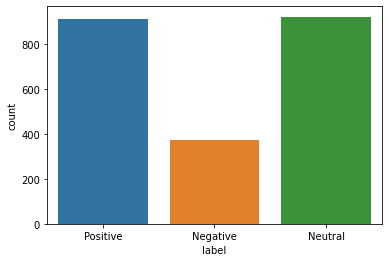

In [4]:
sns.countplot(x="label",data=data)

In [14]:
# download stopwords and wordnet lemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [15]:
def preprocess(text):
    # remove special characters and digits
    text = re.sub('[^a-zA-Z]', ' ', text)
    # convert to lowercase
    text = text.lower()
    # split into words
    words = text.split()
    # remove stopwords
    stopword_list = set(stopwords.words('english'))
    words = [w for w in words if w not in stopword_list]
    # stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    # join the words back into a string
    text = ' '.join(words)
    return text

In [16]:
# apply preprocessing function to the content column
data['content'] = data['content'].apply(preprocess)

In [17]:
data

,Unnamed: 0,content,label
0,0,research use deep learn simul chlorophyl amp p...,Positive
1,1,conserv govern evil rishisunak climatechang co...,Negative
2,2,texa oilfield wast compani contribut regul ove...,Negative
3,3,epic california snowpack deepest decad thank c...,Negative
4,4,climatechang real hoax biden obama gore ocean ...,Negative
...,...,...,...
2200,353,team bit bit com diversityequityinclus dei soc...,Neutral
2201,354,team bit bit com diversityequityinclus dei soc...,Neutral
2202,355,need guidanc identifi sustain initi leader org...,Positive
2203,356,team bit bit com diversityequityinclus dei soc...,Neutral


In [29]:
# Get indices of positive examples
positive_indices = data[data['label'] == 'Positive'].index

In [30]:
# Randomly select subset of positive examples
n_samples = len(positive_indices)
subset_indices = np.random.choice(positive_indices, size=n_samples//2, replace=False)


In [32]:
# Get indices of neutral examples
neutral_indices = data[data['label'] == 'Neutral'].index

In [33]:
# Randomly select subset of neutral examples
n_samples = len(neutral_indices)
neutral_indices = np.random.choice(neutral_indices, size=n_samples//2, replace=False)


In [34]:
# Get indices of negative examples
negative_indices = data[data['label'] == 'Negative'].index

In [35]:
# Concatenate subset of positive examples with all negative and neutral examples
data_undersampled = pd.concat([data.loc[subset_indices], data.loc[negative_indices], data.loc[neutral_indices]])

In [36]:
# Shuffle the rows of the new dataframe
data_undersampled = data_undersampled.sample(frac=1).reset_index(drop=True)

In [37]:
data_undersampled

,Unnamed: 0,content,label
0,10,iambrainstorm wordpress com dem aap arvindkejr...,Negative
1,80,wonder recent wild weather caus climatechang w...,Negative
2,4,climatechang real hoax biden obama gore ocean ...,Negative
3,162,breakfreefromplast global movement envis futur...,Positive
4,860,speak th intern forestri amp environ symposium...,Neutral
...,...,...,...
1283,1185,object speak drive car produc emiss convent ga...,Positive
1284,170,announc two new phd posit one new postdoc sust...,Positive
1285,73,typic type beehiv use beekeep shenzhen area mu...,Neutral
1286,1093,suncor shutdown fire pollut demand transpar pu...,Negative


In [39]:
data_undersampled['label'].value_counts()

Neutral     460
Positive    455
Negative    373
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

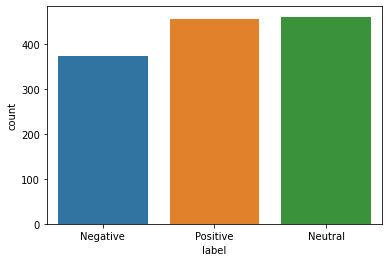

In [40]:
# Create a countplot of the labels
sns.countplot(x='label', data=data_undersampled)

In [41]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['content'], data['label'], test_size=0.2, random_state=42)


In [42]:
# create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)


In [43]:
# fit the vectorizer to the training data and transform the training and testing data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [44]:
# create a Count Vectorizer
count_vectorizer = CountVectorizer(max_features=5000)

In [45]:
# fit the vectorizer to the training data and transform the training and testing data
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

In [46]:
# combine the TF-IDF and Count vectors
X_train_combined = hstack([X_train_tfidf, X_train_count])
X_test_combined = hstack([X_test_tfidf, X_test_count])

In [48]:
# train a logistic regression classifier on the combined vectorized data
clf = LogisticRegression()
clf.fit(X_train_combined, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [49]:
# predict the labels on the testing data
y_pred = clf.predict(X_test_combined)

In [50]:
# calculate the accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

ValueError: ignored

In [51]:
from sklearn.metrics import classification_report

# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

    Negative       0.37      0.22      0.27        88
     Neutral       0.46      0.43      0.44       189
    Positive       0.41      0.53      0.47       164

    accuracy                           0.43       441
   macro avg       0.41      0.39      0.39       441
weighted avg       0.42      0.43      0.42       441

